# Deep Q-learning

In [23]:
import gymnasium as gym
import math
import random
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Environment and device

In [24]:
env = gym.make("ALE/Breakout-v5") 
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
FIRE = 1

## Replay buffer

In [25]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

## Neural network

In [26]:
class DQN(nn.Module):
    def __init__(self, action_size = 3):
        super(DQN, self).__init__() 
        self.action_size = action_size
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 4, out_channels = 32, kernel_size = 8, stride = 4),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1),
            nn.ReLU(),
        )
        self.dense = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, self.action_size)
        )
    def forward(self, frame):
        h = self.conv(frame)
        h = h.view(h.shape[0], -1)
        return self.dense(h)

## Preprocessing

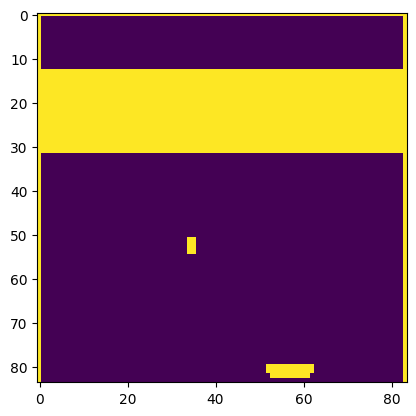

In [27]:
from skimage.color import rgb2gray
from skimage.transform import resize

# https://github.com/bchao1/Breakout-Deep-Q-Learning/blob/master/src/train.py
def pre_process(observe):
    processed_observe = np.uint8(resize(rgb2gray(observe)[31:-14,7:-7], (84, 84), mode='constant') * 255) > 0
    return processed_observe

state, info = env.reset()
obs, rwd, termin, trunc, info = env.step(FIRE)
obs, rwd, termin, trunc, info = env.step(FIRE)
obs, rwd, termin, trunc, info = env.step(FIRE)


plt.imshow(pre_process(obs))
plt.show()

## Parameters for training

In [28]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4   # to decrease

## Variables initialization

In [29]:
main_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(main_net.state_dict())

optimizer = optim.AdamW(main_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

## Select action with epsilon-greedy policy

In [30]:
steps_done = 0
def update_epsilon():
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    return eps_threshold

def select_action(state, eps_threshold):
    global steps_done
    sample = random.random()
    steps_done += 1
    # epsilon-greedy
    if sample > eps_threshold:
        with torch.no_grad():
            return torch.argmax(main_net(state)).view(1, 1)
    else:
        # print(torch.randint(0, 3, size=(1,1), device=device))
        return torch.randint(0, 3, size=(1,1), device=device)

## One step optimization

In [31]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # print(action_batch.shape)
    q_values = main_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # using target_net to improve stability because V(s') = max Q(s', a') that is used in the update rule
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        expected_q_values = (next_state_values * GAMMA) + reward_batch

    loss = nn.SmoothL1Loss()(q_values, expected_q_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(main_net.parameters(), 100)
    optimizer.step()

In [32]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 4

## Training

In [33]:
def soft_update():
    # Soft update of the target network's weights
    # θ′ ← τ θ + (1 −τ )θ′
    target_net_state_dict = target_net.state_dict()
    main_net_state_dict = main_net.state_dict()
    for key in main_net_state_dict:
        target_net_state_dict[key] = main_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

In [34]:
def real_action(action):
    if action == 0:
        return 0
    elif action == 1:
        return 2
    else:
        return 3

Complete


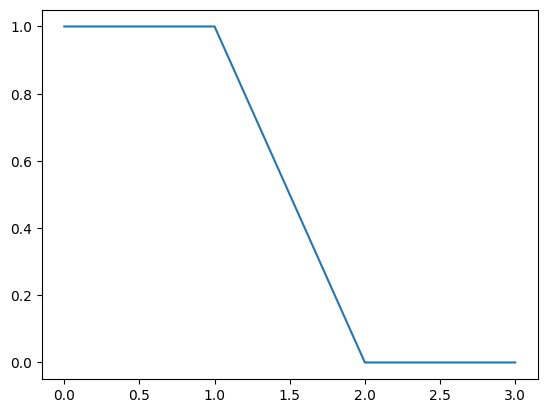

In [35]:
def hist_input(history):
    if history is not None:
        return torch.tensor(history / 255.0, dtype = torch.float, device=device)
    else:
        return history

training_rewards = []
for i_episode in range(num_episodes):
    state, info = env.reset()
    obs, rwd, termin, trunc, info = env.step(FIRE)
    
    history = np.stack((pre_process(obs), pre_process(obs), pre_process(obs), pre_process(obs)))
    history = np.expand_dims(history, axis = 0)
    
    episode_rewards = []
    for t in count():
        action = select_action(hist_input(history), update_epsilon())
        obs, rwd, termin, trunc, new_info = env.step(real_action(action.item()))
        episode_rewards.append(rwd)
        reward = torch.tensor([rwd], device=device)
        done = termin or trunc
        if termin:
            next_history = None
        else:
            next_state = pre_process(obs)
            next_state = np.reshape([next_state], (1, 1, 84, 84))
            next_history = np.append(next_state, history[:, :3, :, :], axis = 1)
            
        memory.push(hist_input(history), action, hist_input(next_history), reward)
        history = next_history
        optimize_model()
        soft_update()
        
        if done:
            break 
        elif new_info['lives'] != info['lives']:
            obs, rwd, termin, trunc, info = env.step(FIRE)
        else:
            info = new_info     
    training_rewards.append(sum(episode_rewards))

plt.plot(training_rewards)
plt.savefig("rewards.png") 
print('Complete')

## Test one game

In [14]:
env = gym.wrappers.RecordVideo(gym.make("ALE/Breakout-v5", render_mode='rgb_array'), "videos")
state, info = env.reset()
env.start_video_recorder()
obs, rwd, termin, trunc, info = env.step(FIRE)
    
history = np.stack((pre_process(obs), pre_process(obs), pre_process(obs), pre_process(obs)))
history = np.expand_dims(history, axis = 0)

for t in count():
    action = select_action(hist_input(history), 0)
    obs, rwd, termin, trunc, new_info = env.step(real_action(action.item()))
    done = termin or trunc
    if termin:
        next_history = None
    else:
        next_state = pre_process(obs)
        next_state = np.reshape([next_state], (1, 1, 84, 84))
        next_history = np.append(next_state, history[:, :3, :, :], axis = 1)

    history = next_history

    if done:
        break 
    elif new_info['lives'] != info['lives']:
        obs, rwd, termin, trunc, info = env.step(FIRE)
    else:
        info = new_info     

print('Complete')

C:\Users\leond\anaconda3\envs\semester\lib\site-packages\gymnasium\wrappers\record_video.py:79: UserWarning: WARN: Overwriting existing videos at C:\Users\leond\DRL_project\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\leond\anaconda3\envs\semester\lib\site-packages\gymnasium\utils\passive_env_checker.py:357: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Moviepy - Building video C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4


Moviepy - Building video C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\leond\DRL_project\videos\rl-video-episode-0.mp4
Complete


In [ ]:
main_net.load_weights("./models/model.ckpt")